# Multi CompSpec

## Intro 

* **Date**: 11/30/2020
* **What**: This is a CompSpec network with a more complicated competition strategy than previous iterations.  This is more similar to how (I envision) neurons in the brain working than the competition we've had thus far.  Basically, each neuron has a bunch of inhibitory synapses feeding into it.  If a value of one of the synapses is greater than the neuron's value, the neuron loses, and it's output is decreased. If the value of the synapse is greater than all of the inputs, it wins, it's value is boosted, and it adjusts its weights to better match the input.  
* **Why**: In the Team CompSpec experiment, the team of networks barely did any better at classification than the individual networks by themselves.  I believe that was in part because the networks were trained in an incredibly similar environment, so there probably wasn't much diversity in the networks constituting the team.  By having competition more distributed and ad hoc, there will be several winners for any particular input, which constitutes a more robust representation of any particular input. 
* **Hopes**: The hope is that with this strategy, the network will be able to make more robust and therefore better predictions of the data.  I also hope to see more diverse weight prototypes with this architecture than before.  We shall see.  
* **Limitations**: There will be less competition per neuron, so it's possible the prototypes learned will be murkier than CompSpec networks with the same number of neurons.  It's unclear whether that will hinder classification accuracy more than the robustness of the network will help classification accuracy.  That remains to be seen.  Also, I should mention that this network requires an entirely new architecture, and detecting bugs might prove fairly difficult.

## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from time import time
from tensorflow.keras.datasets import mnist
from tqdm import tqdm

L = 28 * 28   #Size of mnist in pixels
S = 60000     #Size of training set

(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X / 255.0

flat_x = np.reshape(train_X, [-1, L])
flat_test = np.reshape(test_X, [-1, L])

In [2]:
def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()   

In [3]:
"""
flat_x: training data
S: Size of training set
L: Size of input
Kx: Num cols of neurons
Ky: Num rows of neurons
N_c: Num Competitive Inputs
Nep: Num epochs
T_s: Number of training inputs
xi: Base learning constant
phi: Specialization ema constant
B: Batch size

zeta: Brutality of exponent
beta: giver of life lol

Returns: (synapse_weights, neuron specialization values)
"""
def multi_comp(flat_x, S, L, Kx, Ky, N_c, Nep, T_s, xi, phi, B, zeta, beta):
    start = time()
    N = Kx * Ky
    
    w = np.abs(np.random.normal(0, 1, (N, L))) # synapses of each neuron
    w = w / np.linalg.norm(w, axis=1).reshape(-1, 1) #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
    
    # Initialize competition neurons matrix
    c_a = []

    for _ in range(N):
        c_a.append(np.random.permutation([1 if i < N_c else 0 for i in range(N)]))

    c_i = np.array(c_a)
    np.fill_diagonal(c_i, 1)
    
    # Initialize specialization
    s = np.zeros(N).reshape(-1, 1) # Specialization for each neuron+

    for ep in range(Nep):
        # Uncomment the following line if you'd like to shuffle the data between epochs
        inputs = flat_x[np.random.permutation(S)]

        for i in tqdm(range(T_s // B)):
            v = inputs[i * B: (i + 1) * B].T #auto transpose
            w_v = w @ v
            p = (np.square(w) @ v)
            
            c_p = (np.exp(-1 * zeta * s) + beta) * p
            
            c_ten = c_p.T * c_i.reshape(N, 1, N)
            c_max = np.max(c_ten, axis=2)
            
            k_del_win = np.where(c_p == c_max, 1, 0)
            
#             o = (1 - c_max + k_del_win) * p
            
            win_mod = k_del_win / np.maximum(np.sum(k_del_win, axis=1), 1).reshape(-1, 1)
            
            win_avg = np.sum(w_v * win_mod, axis=1).reshape(-1, 1)
            v_avg = win_mod @ v.T
            
#             w += (v_avg - (win_avg * w)) * xi
            w += (v_avg - (win_avg * w)) * (np.exp(-1 * zeta * s) + beta) * xi
            
            s[win_avg > 0] *= (1 - phi)
            s += phi * np.sum(p * win_mod, axis=1).reshape(-1, 1)
                        

        draw_weights(w, Kx, Ky)
        
    print("Max val: ", np.amax(s), "Min value: ", np.amin(s), "Mean val: ", np.mean(s), "Std: ", np.std(s))
    print("Elapsed time: ", time() - start, " seconds")
    
    return (w, c_i)

In [84]:
"""
flat_x: training data
S: Size of training set
L: Size of input
Kx: Num cols of neurons
Ky: Num rows of neurons
N_c: Num Competitive Inputs
Nep: Num epochs
T_s: Number of training inputs
xi: Base learning constant
phi: Specialization ema constant
B: Batch size

zeta: Brutality of exponent
beta: giver of life lol

Returns: (synapse_weights, neuron specialization values)
"""
def multi_comp_tricky_boi(flat_x, S, L, Kx, Ky, N_c, Nep, T_s, xi, B):
    start = time()
    N = Kx * Ky
    
    w = flat_x[np.random.permutation(S), :][:N]
    w = w / np.linalg.norm(w, axis=1).reshape(-1, 1) #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
    
    # Initialize competition neurons matrix
    c_a = []

    for _ in range(N):
        c_a.append(np.random.permutation([1 if i < N_c else 0 for i in range(N)]))

    c_i = np.array(c_a)
    np.fill_diagonal(c_i, 1)

    for ep in range(Nep):
        # Uncomment the following line if you'd like to shuffle the data between epochs
        inputs = flat_x[np.random.permutation(S)]

        for i in tqdm(range(T_s // B)):
            v = inputs[i * B: (i + 1) * B].T #auto transpose
            w_v = w @ v
            p = (np.square(w) @ v)
            
            c_ten = p.T * c_i.reshape(N, 1, N)
            c_max = np.max(c_ten, axis=2)
            
            k_del_win = np.where(p == c_max, 1, 0)
            
            o = (1 - c_max + k_del_win) * p
            
            win_mod = k_del_win / np.maximum(np.sum(k_del_win, axis=1), 1).reshape(-1, 1)
            
            win_avg = np.sum(w_v * win_mod, axis=1).reshape(-1, 1)
            v_avg = win_mod @ v.T
            
            w += (v_avg - (win_avg * w)) * xi

#             w = w / np.linalg.norm(w, axis=1).reshape(-1, 1)
            

        draw_weights(w, Kx, Ky)

    print("Elapsed time: ", time() - start, " seconds")
    
    return (w, c_i)

## Analysis Dialog

Ode to joy, it works!!  After writing the code on my whiteboard, I realized I hadn't taken specialization into account when calculating the competition tensor, so I had to rig it a bit.  I had wanted to scale the losers by the winner, but that doesn't really work with the competition tensor.  I might just scale them by themselves, or by a constant factor.  We'll see. 

Anyway, let's look at how this does for 100 neurons using the typical CompSpec constants, but with different values of N_c

<IPython.core.display.Javascript object>


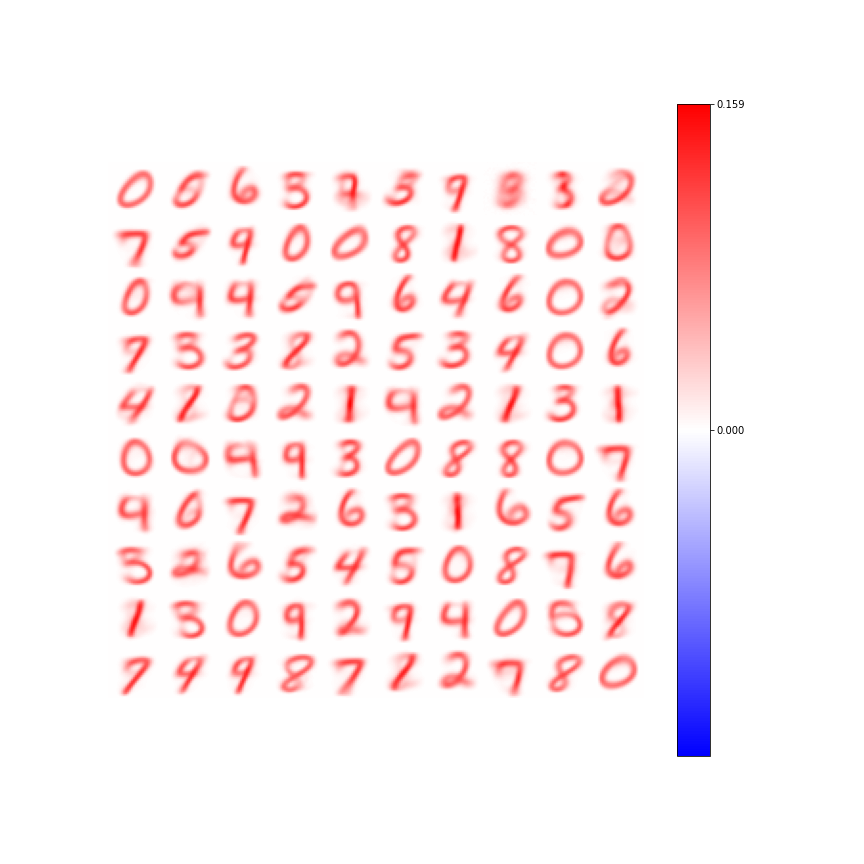

100%|███████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 29.97it/s]


Max val:  0.6646733404350175 Min value:  0.04367613929992939 Mean val:  0.5629666761597992 Std:  0.06507421129833289
Elapsed time:  21.817199230194092  seconds


<IPython.core.display.Javascript object>


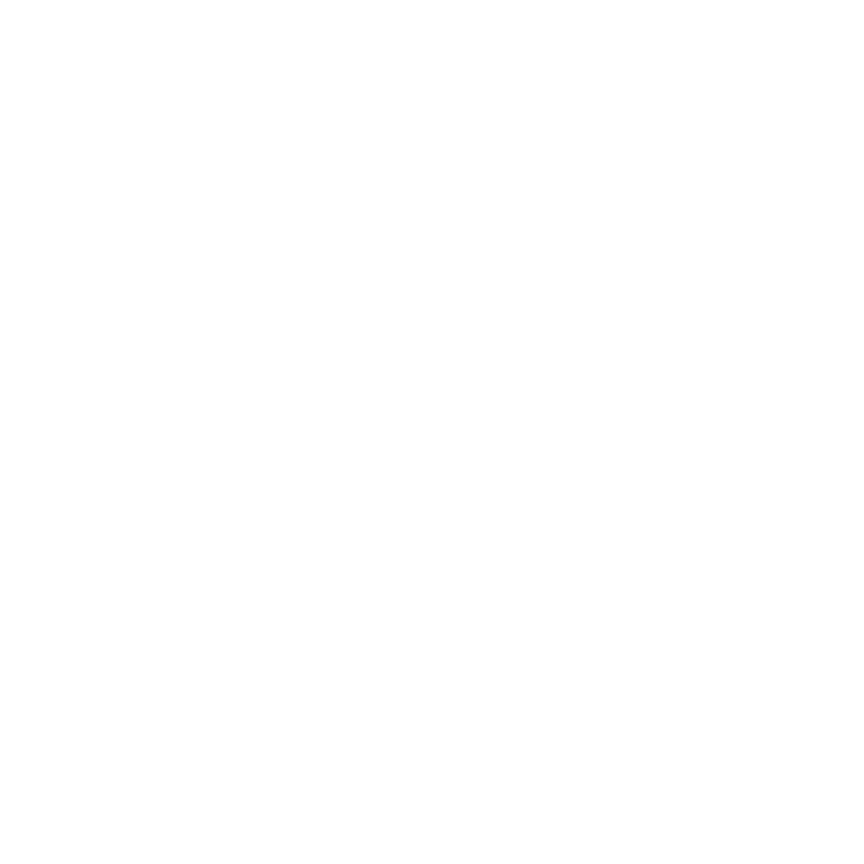

In [100]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 10
Ky = 10
Nep = 5
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.01

N_c = 50

B = 500 #Batch size

w, c_i = multi_comp(flat_x, S, L, Kx, Ky, N_c, Nep, T_s, xi, phi, B, zeta, beta)

Just a quick comment, it's kinda interesting that we're seeing that fuzzy three up there at the top.  I guess it's just winning most of the inputs, perhaps because it's inputs are more specialized.  That actually might be a recurring cycle because if the fuzzy three is winning most of the general inputs, then the neurons it enters and competes with might become more specialized.  Interesting!

Also, I meant to start with N_c = 5 and work up, so I'll do that now.

<IPython.core.display.Javascript object>


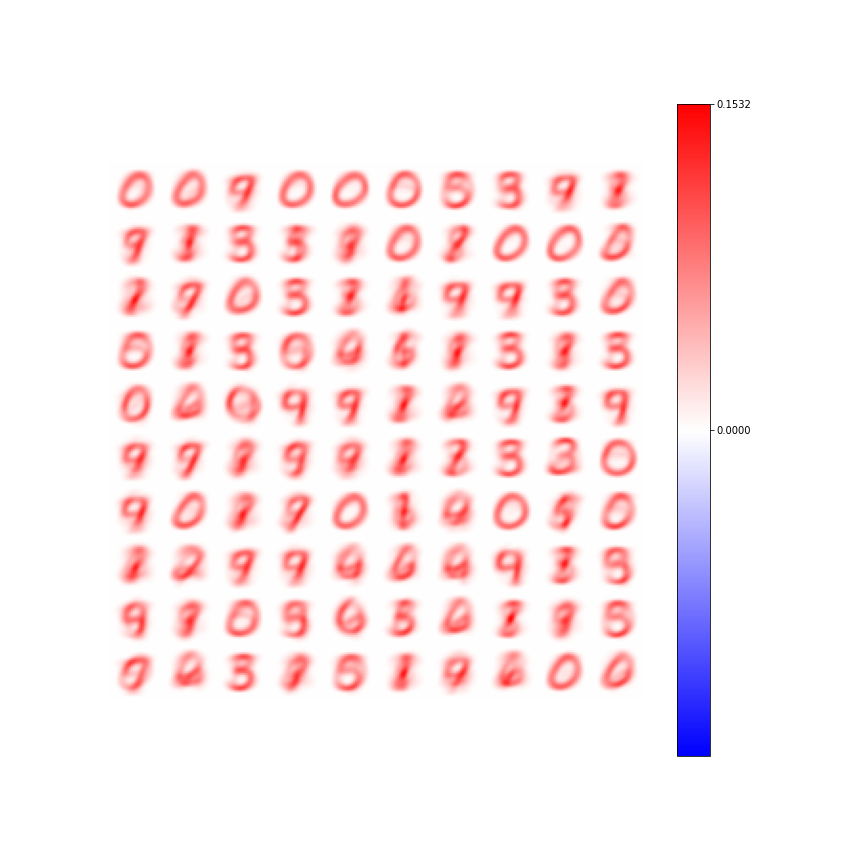

100%|███████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 31.44it/s]


Max val:  0.5446481018118828 Min value:  0.4067621794544681 Mean val:  0.4548339398526764 Std:  0.029266239925097883
Elapsed time:  21.083929538726807  seconds


<IPython.core.display.Javascript object>


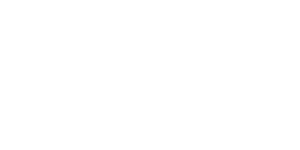

In [101]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 10
Ky = 10
Nep = 5
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.01

N_c = 5

B = 500 #Batch size

w, c_i = multi_comp(flat_x, S, L, Kx, Ky, N_c, Nep, T_s, xi, phi, B, zeta, beta)

<IPython.core.display.Javascript object>


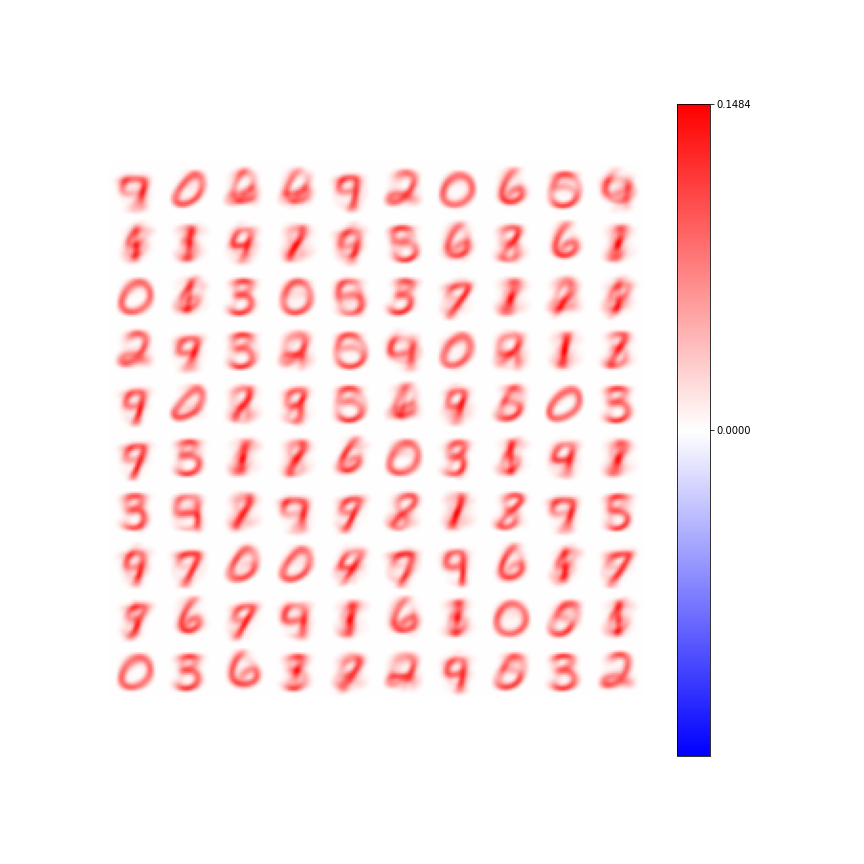

100%|███████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 31.15it/s]


Max val:  0.5925711959610901 Min value:  0.4338155749669577 Mean val:  0.48942136440080247 Std:  0.029747019058974773
Elapsed time:  21.34873914718628  seconds


<IPython.core.display.Javascript object>


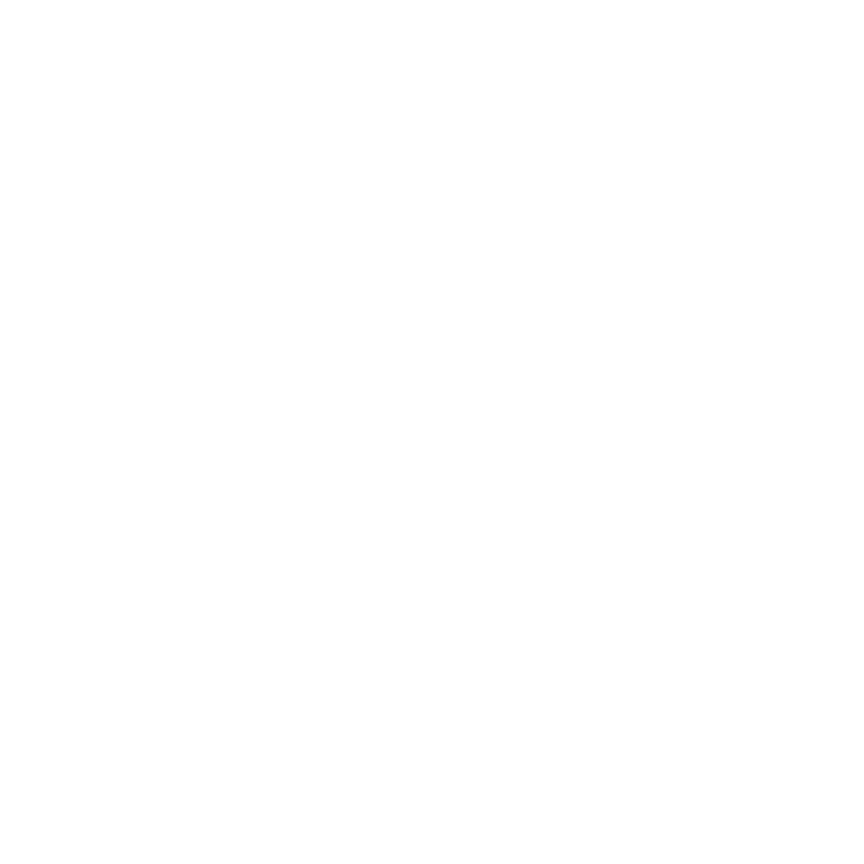

In [102]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 10
Ky = 10
Nep = 5
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.01

N_c = 10

B = 500 #Batch size

w, c_i = multi_comp(flat_x, S, L, Kx, Ky, N_c, Nep, T_s, xi, phi, B, zeta, beta)

<IPython.core.display.Javascript object>


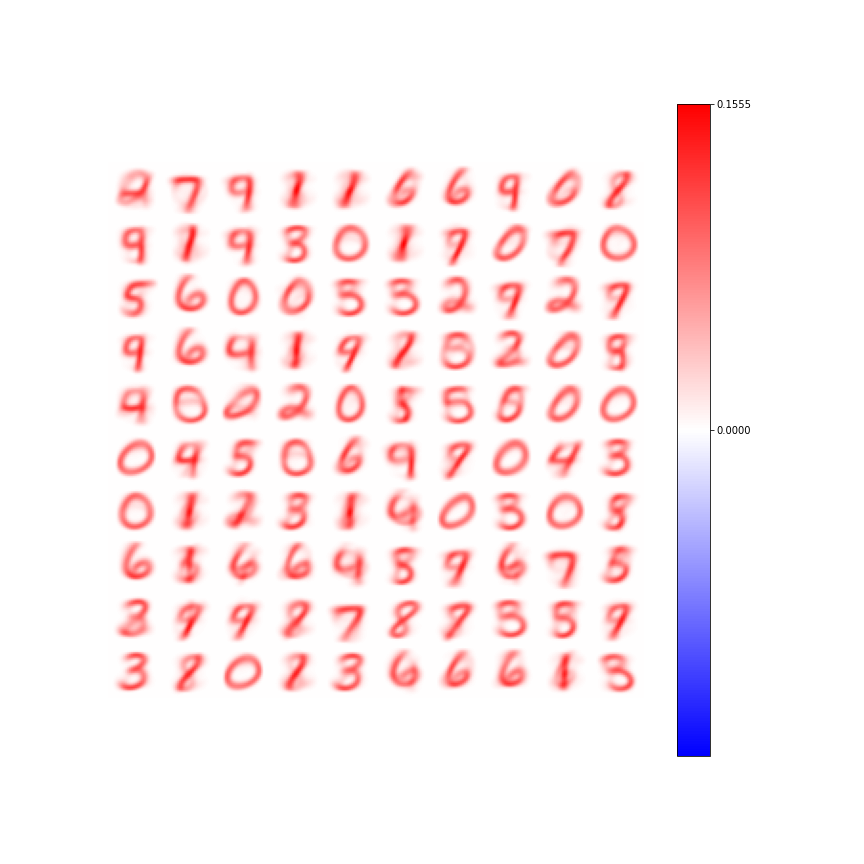

100%|███████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 30.69it/s]


Max val:  0.6084026548115087 Min value:  0.44452513245417397 Mean val:  0.5245801835358731 Std:  0.03172163686551346
Elapsed time:  21.350011348724365  seconds


<IPython.core.display.Javascript object>


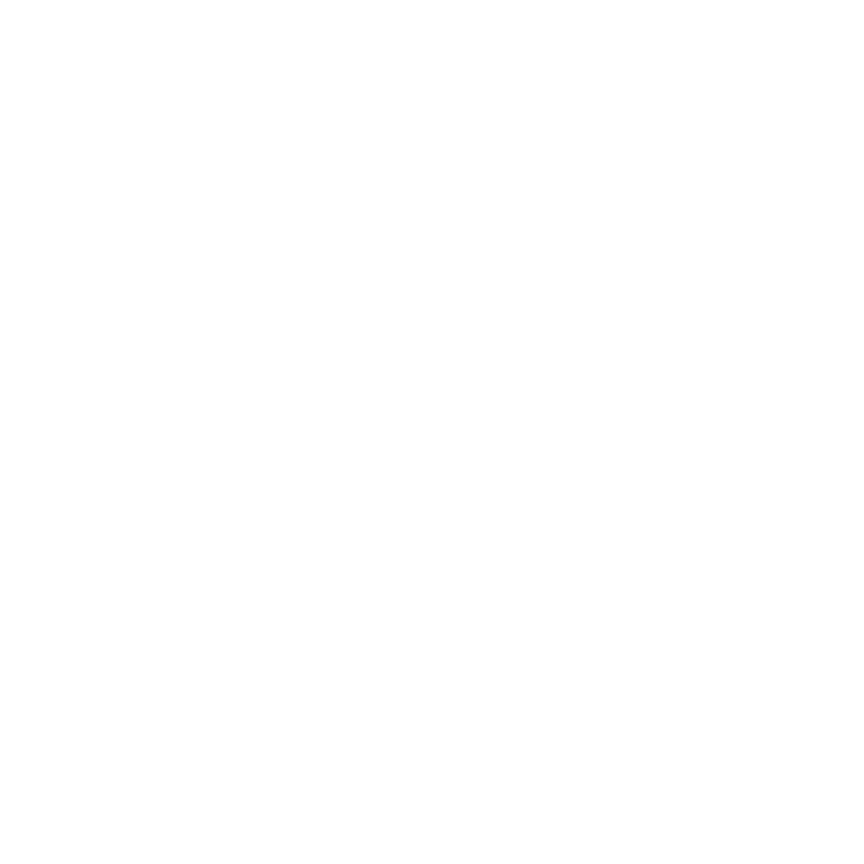

In [103]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 10
Ky = 10
Nep = 5
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.01

N_c = 20

B = 500 #Batch size

w, c_i = multi_comp(flat_x, S, L, Kx, Ky, N_c, Nep, T_s, xi, phi, B, zeta, beta)

<IPython.core.display.Javascript object>


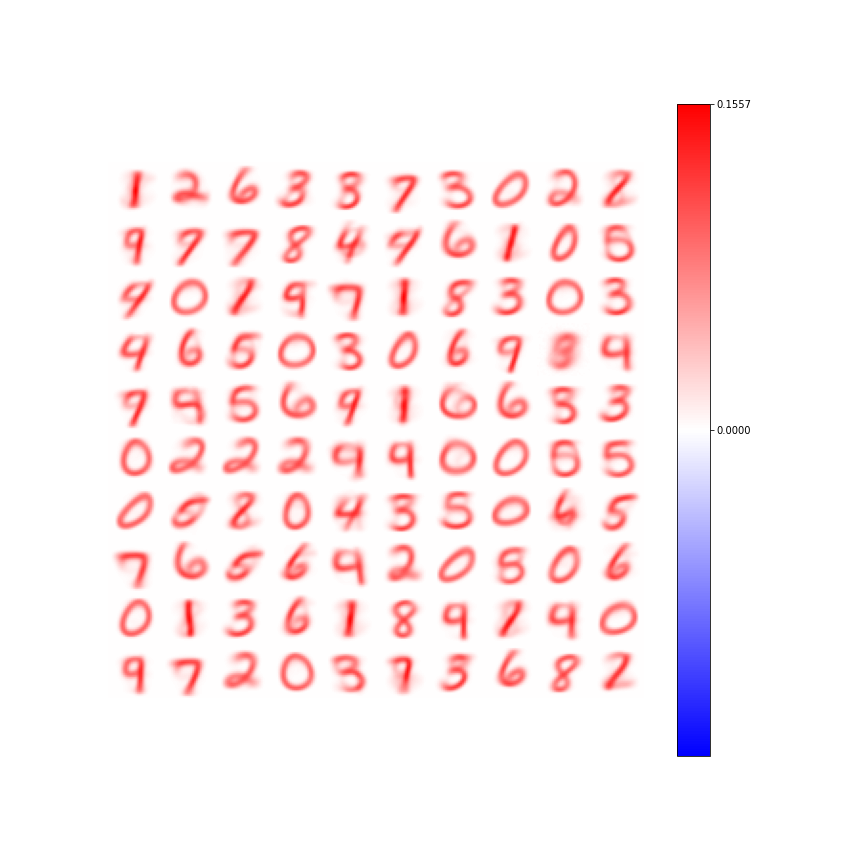

100%|███████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 30.50it/s]


Max val:  0.652164278583792 Min value:  0.04302222317126563 Mean val:  0.5536656326839555 Std:  0.06395381349296404
Elapsed time:  21.570471048355103  seconds


<IPython.core.display.Javascript object>


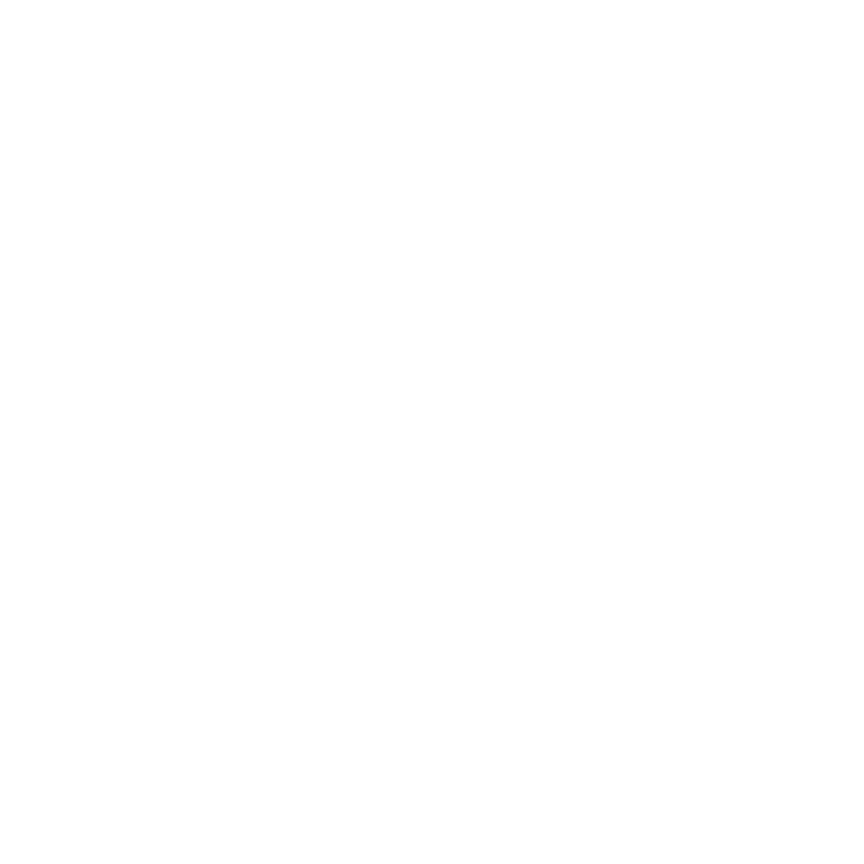

In [104]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 10
Ky = 10
Nep = 5
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.01

N_c = 40

B = 500 #Batch size

w, c_i = multi_comp(flat_x, S, L, Kx, Ky, N_c, Nep, T_s, xi, phi, B, zeta, beta)

<IPython.core.display.Javascript object>


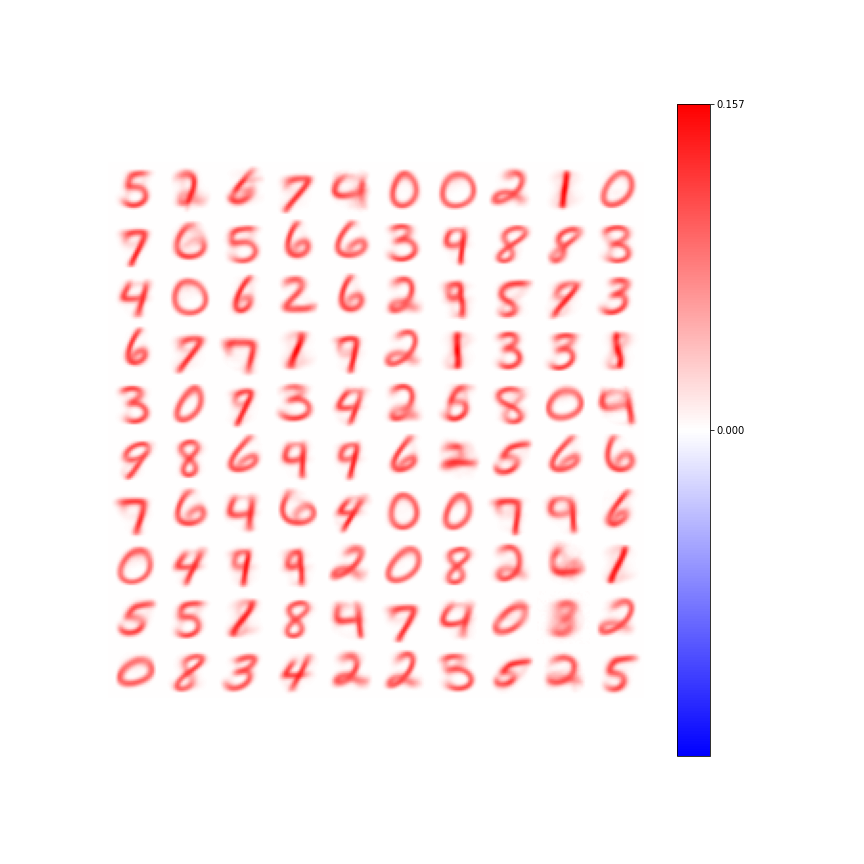

100%|███████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 30.41it/s]


Max val:  0.6602357421235856 Min value:  0.04417670060835793 Mean val:  0.5701805975311561 Std:  0.06441047680224277
Elapsed time:  21.597042083740234  seconds


<IPython.core.display.Javascript object>


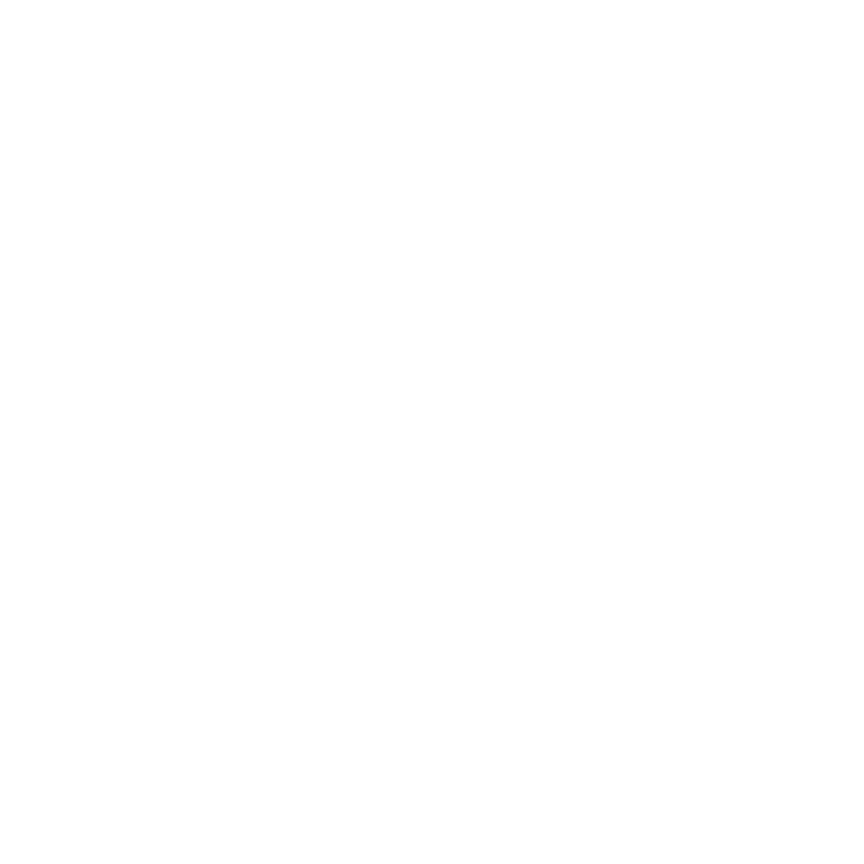

In [105]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 10
Ky = 10
Nep = 5
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.01

N_c = 70

B = 500 #Batch size

w, c_i = multi_comp(flat_x, S, L, Kx, Ky, N_c, Nep, T_s, xi, phi, B, zeta, beta)

<IPython.core.display.Javascript object>


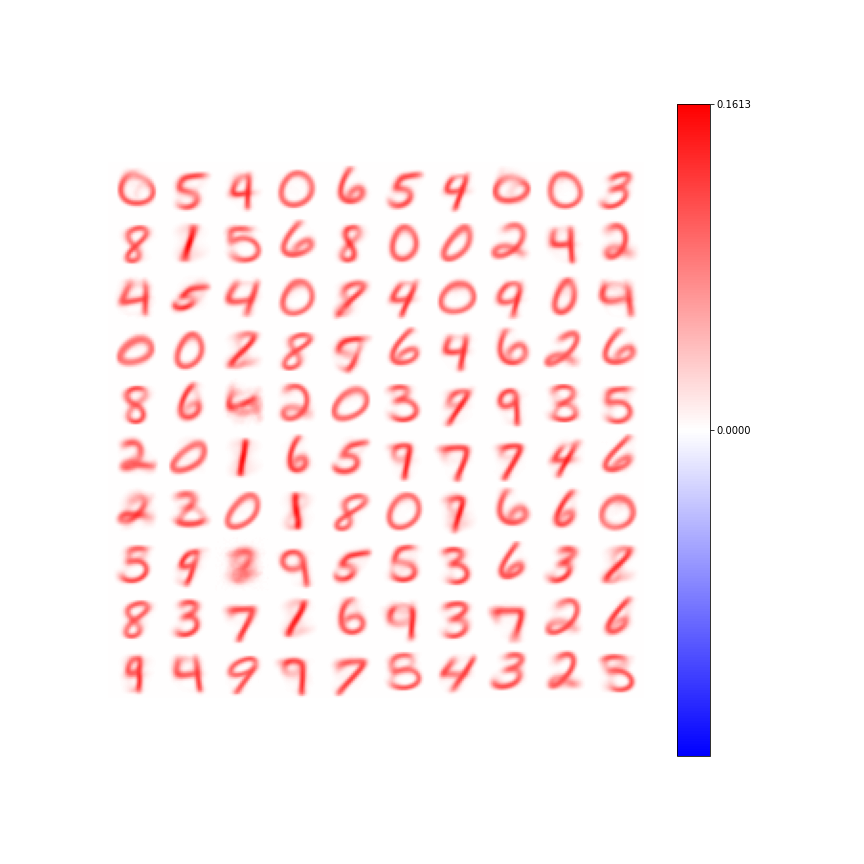

100%|███████████████████████████████████████████████████████████████| 120/120 [00:04<00:00, 29.52it/s]


Max val:  0.6802210461994316 Min value:  0.04003753656782927 Mean val:  0.5804239569855495 Std:  0.06897510026888681
Elapsed time:  21.982736825942993  seconds


<IPython.core.display.Javascript object>


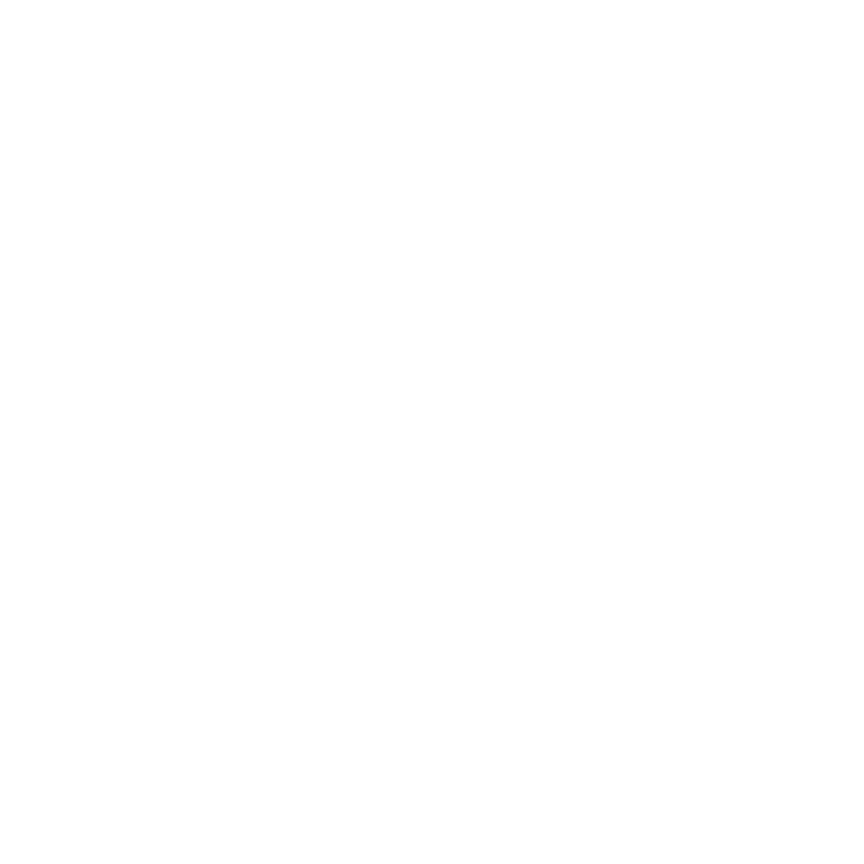

In [106]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 10
Ky = 10
Nep = 5
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.01

N_c = 90

B = 500 #Batch size

w, c_i = multi_comp(flat_x, S, L, Kx, Ky, N_c, Nep, T_s, xi, phi, B, zeta, beta)

<IPython.core.display.Javascript object>


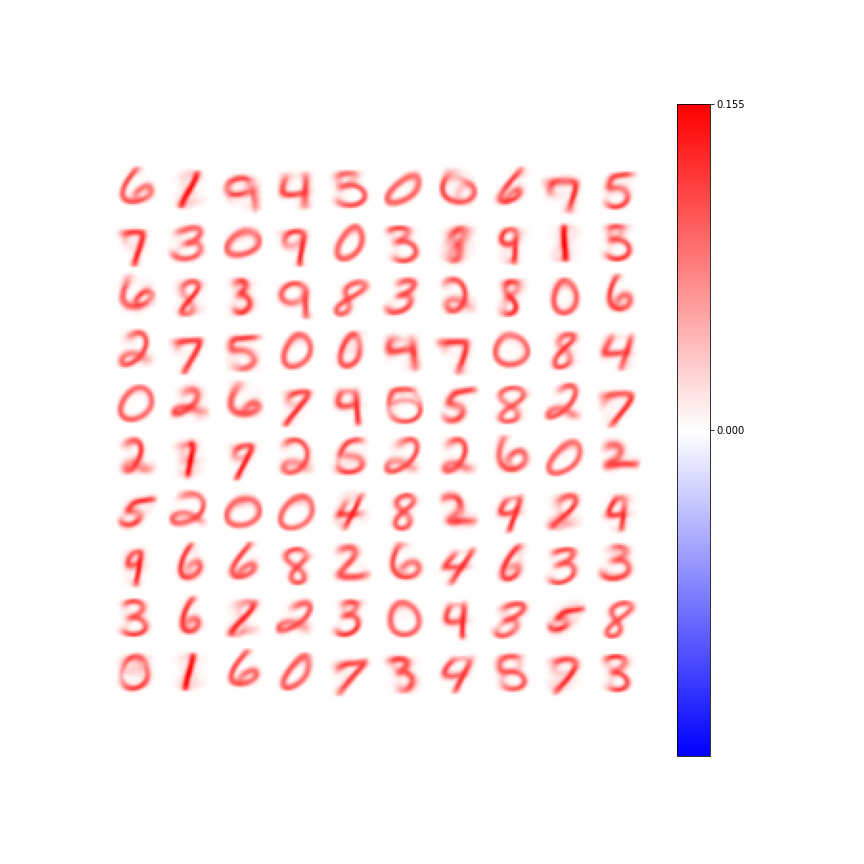

100%|███████████████████████████████████████████████████████████████| 120/120 [00:03<00:00, 30.16it/s]


Max val:  0.6814639195708208 Min value:  0.043716750243460806 Mean val:  0.5720674801017146 Std:  0.07608578152914983
Elapsed time:  21.573801517486572  seconds


<IPython.core.display.Javascript object>


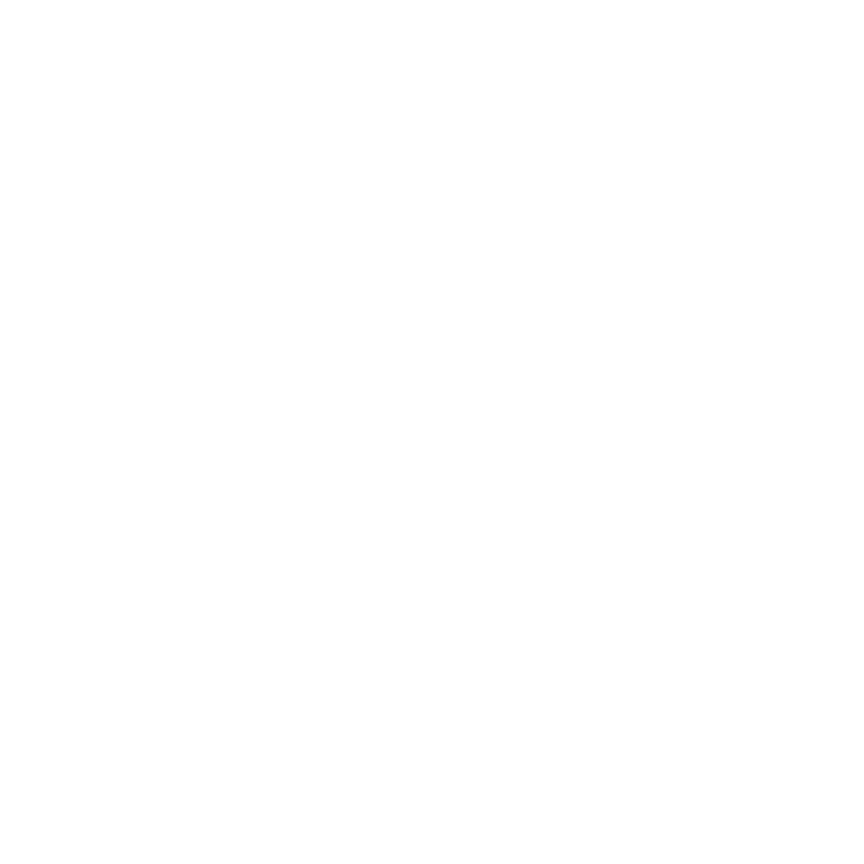

In [109]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 10
Ky = 10
Nep = 5
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.01

N_c = 100

B = 500 #Batch size

w, c_i = multi_comp(flat_x, S, L, Kx, Ky, N_c, Nep, T_s, xi, phi, B, zeta, beta)

Gosh, it's kinda annoying how long the matplotlib notebooks make the cells.  Whatever.  This is actually super interesting.  Obviously the networks with a really small N_c don't have as good of prototypes, but even with N_c = 20, we're seeing distinct prototypes.  And, I mean, with that number of neuron, 4 would probably be winning per input, so that's a fairly robust output for a given input.  However, the real test is whether multi-comp beats OG comp with the classifier I came up with yesterday?  Two days ago?  Basically the one that learns WTA classification.  But now, there are several winners.  Hehehe.  

Ok, before I bring in the classifier, I'm going to see how this does with 400 neurons.

Oh, I should also mention that this bad boi is only like 4x slower than CompSpec, which is wonderful news.  I guess the tensor computations aren't as incredibly long as I thought.  I'm nervous that 400 neurons will be 16x as slow.  But we'll see right now, I suppose.

Again, I'll try with a range of N_c

<IPython.core.display.Javascript object>


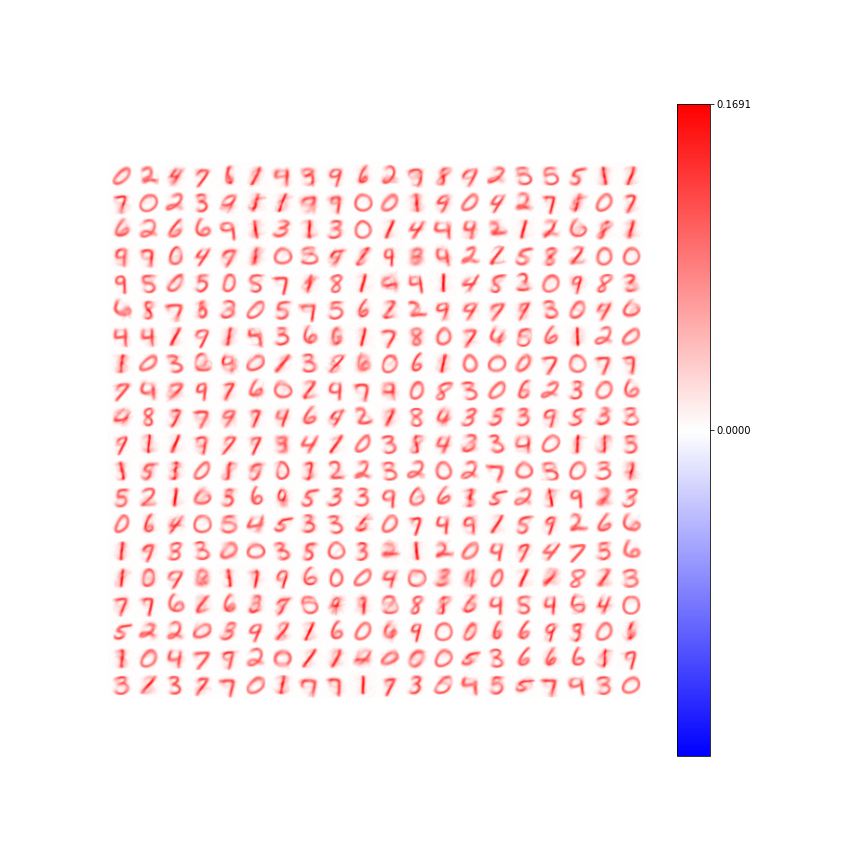

100%|███████████████████████████████████████████████████████████████| 120/120 [00:56<00:00,  2.18it/s]


Max val:  0.18623084454419606 Min value:  0.042303464867473495 Mean val:  0.15174629358885236 Std:  0.028940618502545794
Elapsed time:  56.91432547569275  seconds


<IPython.core.display.Javascript object>


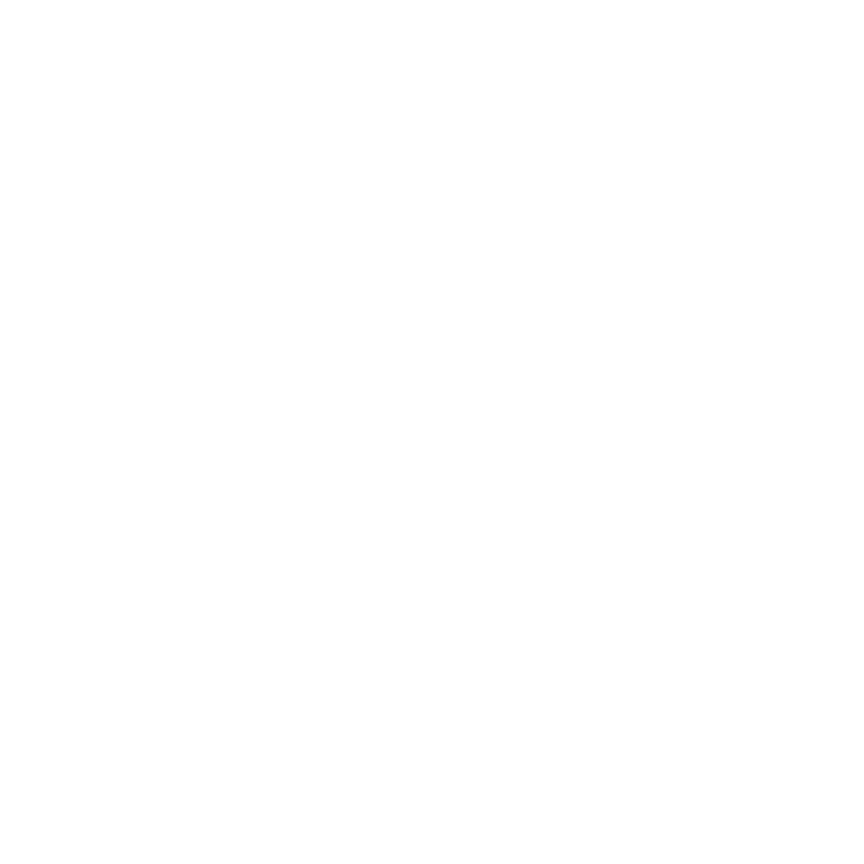

In [110]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 20
Ky = 20
Nep = 1
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.01

N_c = 100

B = 500 #Batch size

w, c_i = multi_comp(flat_x, S, L, Kx, Ky, N_c, Nep, T_s, xi, phi, B, zeta, beta)

Oh shoot, that took a very long time.  Yikes.  Let me try with a bigger batch size.  Imma run outa RAM soon.

<IPython.core.display.Javascript object>


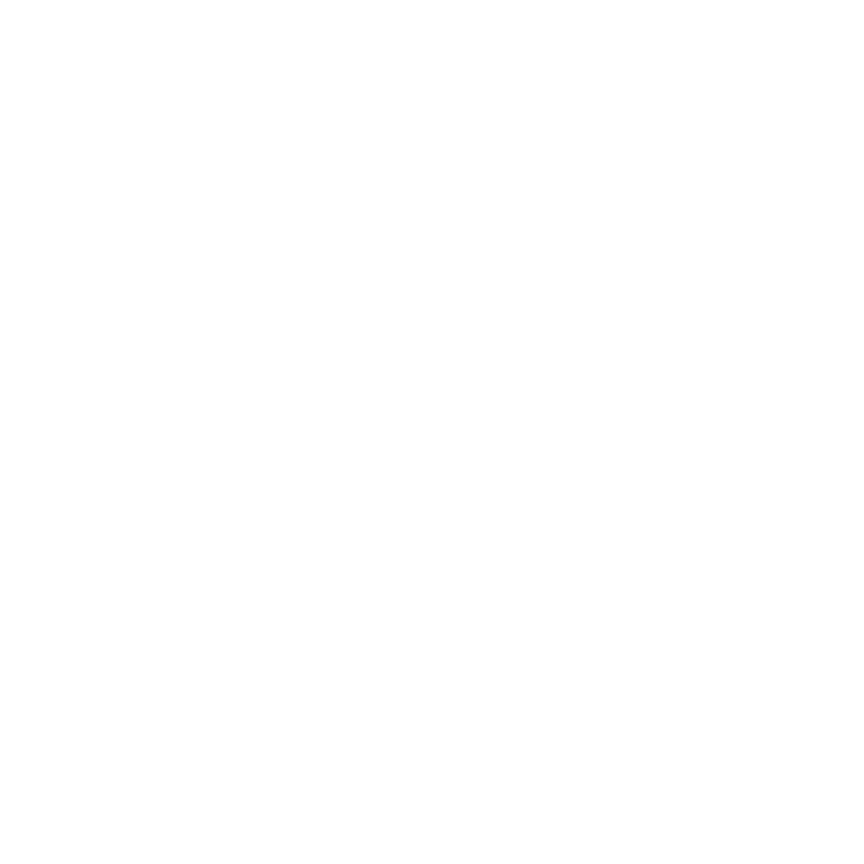

 15%|█████████▉                                                        | 9/60 [00:08<00:47,  1.07it/s]


KeyboardInterrupt: 

In [4]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 20
Ky = 20
Nep = 1
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.01

N_c = 100

B = 1000 #Batch size

w, c_i = multi_comp(flat_x, S, L, Kx, Ky, N_c, Nep, T_s, xi, phi, B, zeta, beta)

Nope, interrupted that bad boi.  It wasn't going any faster.  Great.  Well, ok.  That's horrific time-scaling.  If this gets good classifications, I might load this bad boi into TensorFlow and see what kind of acceleration we can get.  Alright, here are four different trials.

<IPython.core.display.Javascript object>


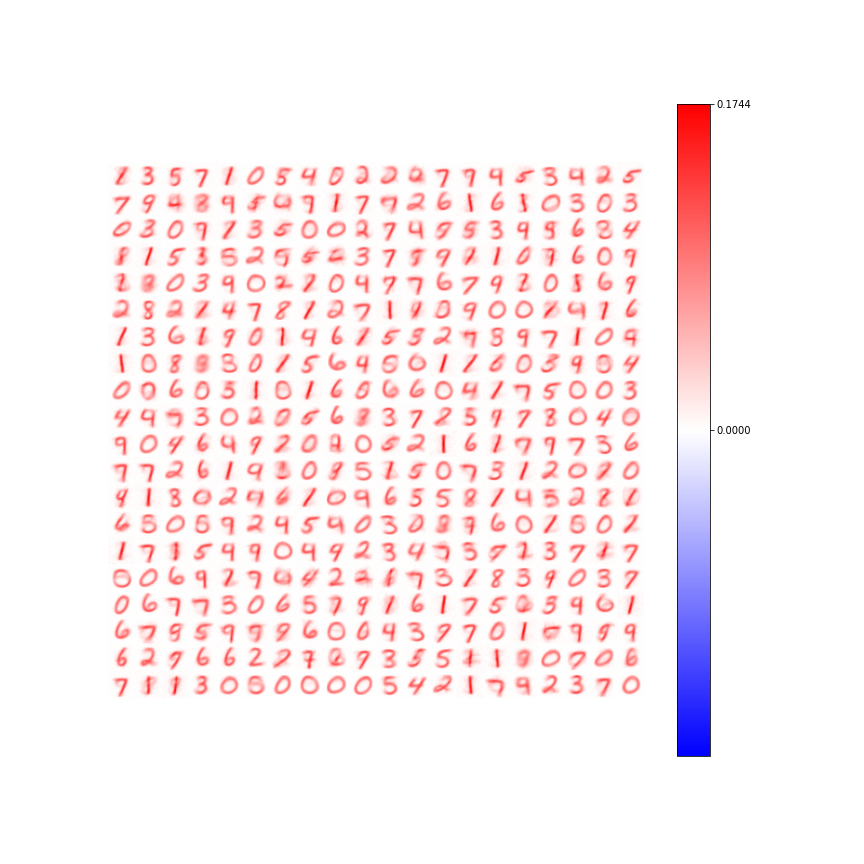

100%|███████████████████████████████████████████████████████████████| 120/120 [00:54<00:00,  2.21it/s]


Max val:  0.23413017505345016 Min value:  0.04044422614319439 Mean val:  0.196225336137653 Std:  0.027944420810297632
Elapsed time:  54.7972891330719  seconds


In [5]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 20
Ky = 20
Nep = 1
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.01

N_c = 50

B = 500 #Batch size

w, c_i = multi_comp(flat_x, S, L, Kx, Ky, N_c, Nep, T_s, xi, phi, B, zeta, beta)

Holy cow!  That's with 50?? Those are pretty darn good prototypes.  I'm going to try to see how quickly it converges.

<IPython.core.display.Javascript object>


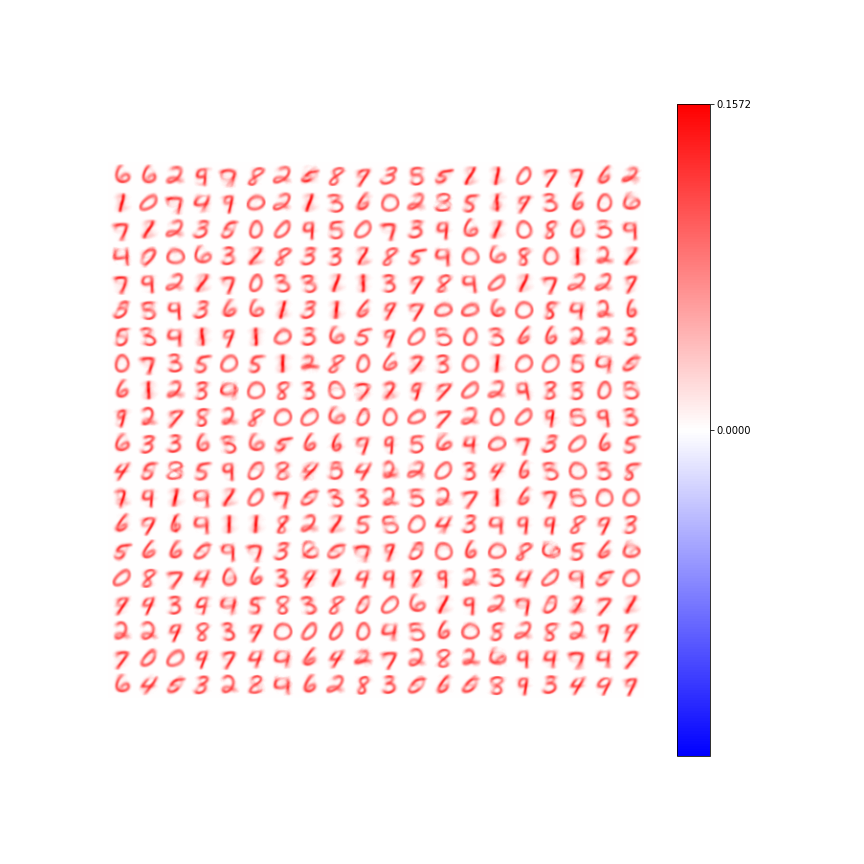

100%|█████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.21it/s]


Max val:  0.22760265138623997 Min value:  0.15983403606091612 Mean val:  0.1976663010551816 Std:  0.01216102869081553
Elapsed time:  57.56431531906128  seconds


In [7]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 20
Ky = 20
Nep = 10
T_s = 6000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.1

N_c = 50

B = 500 #Batch size

w, c_i = multi_comp(flat_x, S, L, Kx, Ky, N_c, Nep, T_s, xi, phi, B, zeta, beta)

Ok, I figured it out.  Basically beta was too small, so the neurons were essentially initializing to random inputs and then staying put.  Still, those prototypes are pretty darn good.  I'm a fan.  Well done, network.

With those same constants, I'm going to do a couple of other N_c

<IPython.core.display.Javascript object>


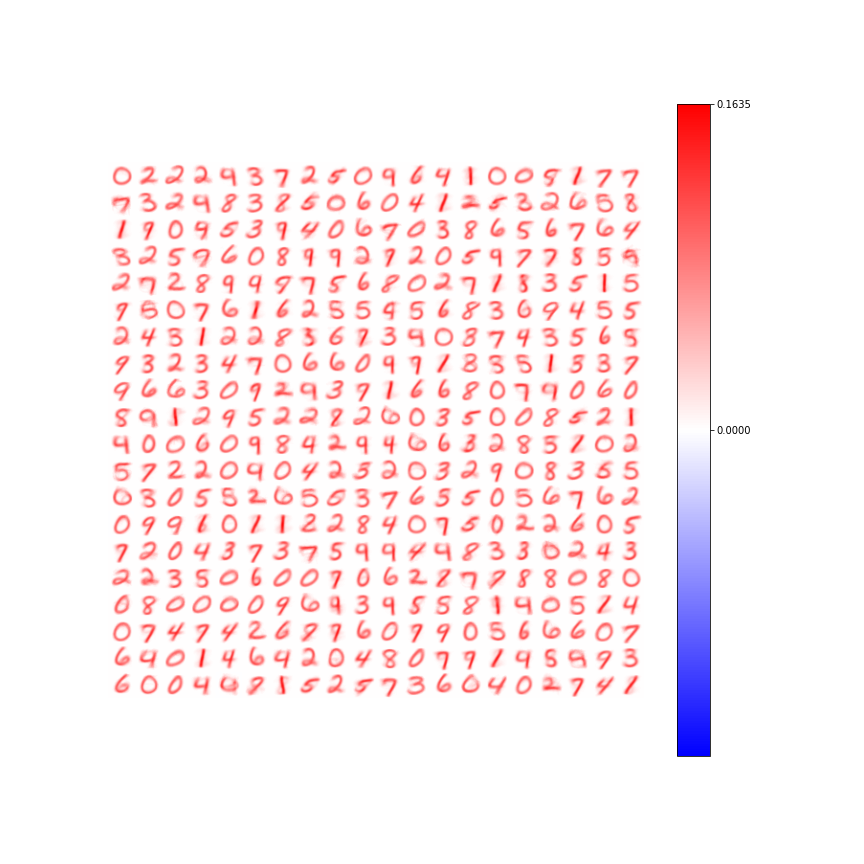

100%|█████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.20it/s]


Max val:  0.19228175239012624 Min value:  0.06028322907423091 Mean val:  0.1599630503475492 Std:  0.014925675337935358
Elapsed time:  58.426196575164795  seconds


In [8]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 20
Ky = 20
Nep = 10
T_s = 6000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.1

N_c = 100

B = 500 #Batch size

w, c_i = multi_comp(flat_x, S, L, Kx, Ky, N_c, Nep, T_s, xi, phi, B, zeta, beta)

Wow, the neurons were pretty much staying put after maybe 7-8 of those mini-epochs.  Interesting.  Here's N_c = 200.

<IPython.core.display.Javascript object>


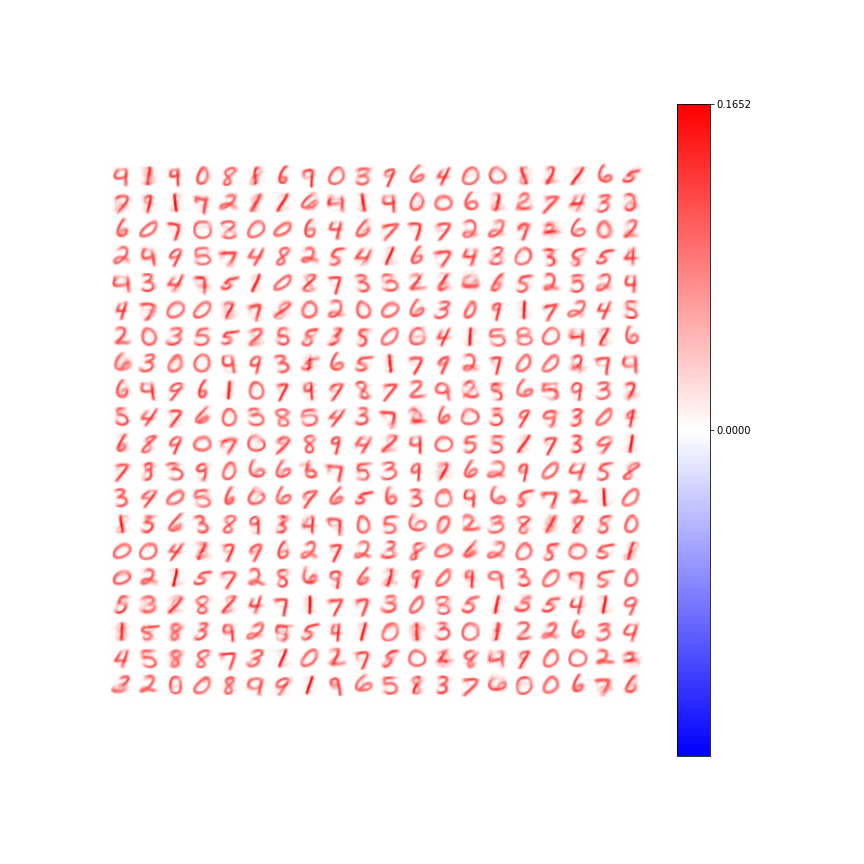

100%|█████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.19it/s]


Max val:  0.1148049376947964 Min value:  0.030260039885299635 Mean val:  0.07327441949488848 Std:  0.014412732923219417
Elapsed time:  59.2890989780426  seconds


In [4]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 20
Ky = 20
Nep = 10
T_s = 6000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.1

N_c = 200

B = 500 #Batch size

w, c_i = multi_comp(flat_x, S, L, Kx, Ky, N_c, Nep, T_s, xi, phi, B, zeta, beta)

Dang it took 8 mini-epochs just to get all the values initialized. I'm going to run this on 15 mini-epochs, and see when the values stop moving.

<IPython.core.display.Javascript object>


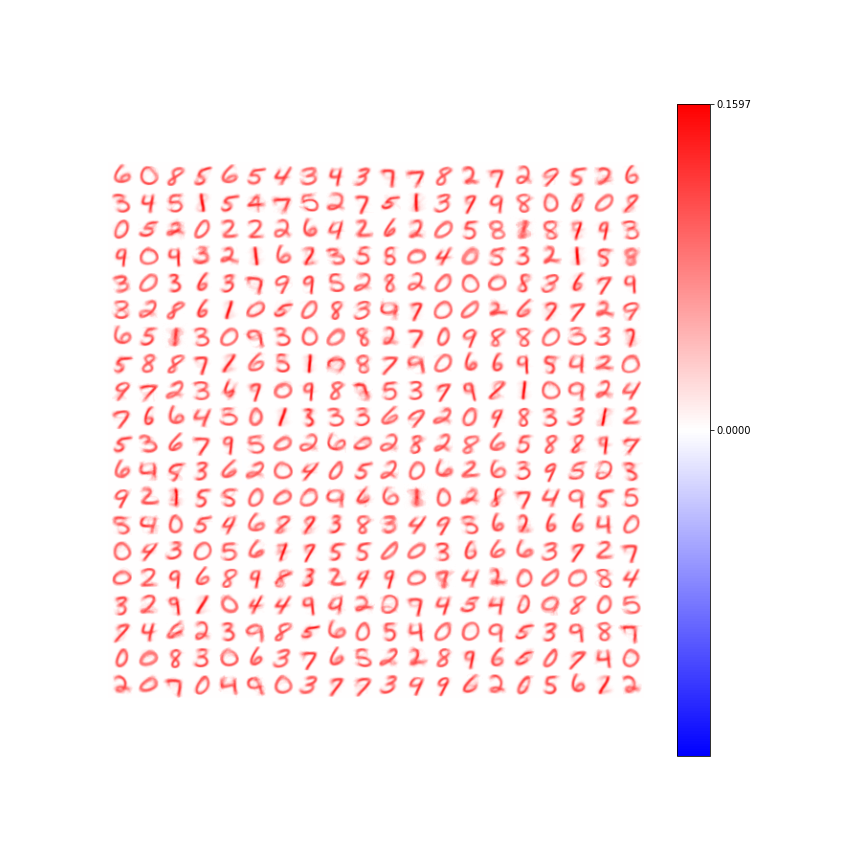

100%|█████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.18it/s]


Max val:  0.21155833174972719 Min value:  0.032764652063505546 Mean val:  0.1594112583235646 Std:  0.03179997991313582
Elapsed time:  88.55910968780518  seconds


In [6]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 20
Ky = 20
Nep = 15
T_s = 6000
xi = 0.1
phi = 2 / 501

zeta = 200
beta = 0.1

N_c = 200

B = 500 #Batch size

w, c_i = multi_comp(flat_x, S, L, Kx, Ky, N_c, Nep, T_s, xi, phi, B, zeta, beta)

Hmm.  The values definitely were still moving around after 15 epochs.  I'm going to hike the zeta.

<IPython.core.display.Javascript object>


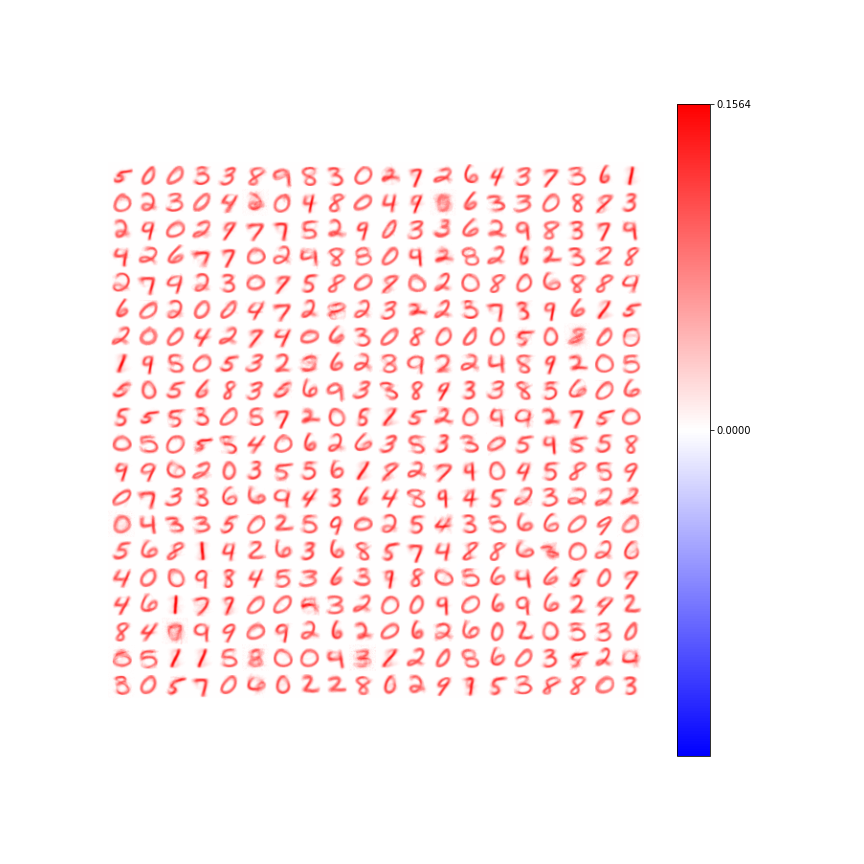

100%|█████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.13it/s]


Max val:  0.32688612260012206 Min value:  0.01530952153702265 Mean val:  0.24695897868678962 Std:  0.0632964139606712
Elapsed time:  88.92217969894409  seconds


In [8]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 20
Ky = 20
Nep = 15
T_s = 6000
xi = 0.1
phi = 2 / 501

zeta = 400
beta = 0.1

N_c = 200

B = 500 #Batch size

w, c_i = multi_comp(flat_x, S, L, Kx, Ky, N_c, Nep, T_s, xi, phi, B, zeta, beta)

Ok.  With that value of zeta, the network initialized after like 4 mini epochs.  I must never forget zeta.  Zeta is the key.  

Now this is pretty interesting.  The prototypes from N_c = 50 are maybe a bit more general than N_c = 200, but not very much.  Also, I'm a big fan of N_c = 50 because that means about 8 neurons are winning for a given input.  That's absolutely fantastic.  
That should hopefully give a pretty darn robust encoding of the input.  

Ok, the only thing to do now is to bring in the classifier I was using in the cookhouse (?? I think that's where it is). 


In [43]:
def class_acc(w, c_i, w_c, N):

#     p = (np.square(w) @ flat_test.T)
    p = w @ flat_test.T

    c_ten = p.T * c_i.reshape(N, 1, N)
    c_max = np.max(c_ten, axis=2)

    k_del_win = np.where(p == c_max, 1, 0)

    res = w_c @ k_del_win
    winners = np.argmax(res, axis=0).reshape(-1)
    
    dubs = np.where(winners == test_y, 1, 0)
    
    incorr = np.where(dubs == 0, test_y, -1)
    
    mis_cls = np.zeros(10)
    
    for i in incorr:
        if i >= 0:
            mis_cls[i] += 1

    num_correct = np.sum(dubs)
    
    print("Misclassifieds: ", mis_cls)
    print("Accuracy: ", 100 * num_correct / test_y.shape[0], "%")

In [49]:
"""
flat_x: training data
S: Size of training set
L: Size of input
Kx: Num cols of neurons
Ky: Num rows of neurons
N_c: Num Competitive Inputs
Nep: Num epochs
T_s: Number of training inputs
xi: Base learning constant
phi: Specialization ema constant
B: Batch size

zeta: Brutality of exponent
beta: giver of life lol

Returns: (synapse_weights, neuron specialization values)
"""

def multi_comp_classification(flat_x, S, L, Kx, Ky, N_c, Nep, Tep, T_s, xi, phi, B, zeta, beta):
    start = time()
    N = Kx * Ky

    
    w = np.abs(np.random.normal(0, 1, (N, L))) # synapses of each neuron
    w = w / np.array([np.linalg.norm(w, axis=1)]).T #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
    s = np.zeros(N).reshape(-1, 1) # Specialization for each neuron+
    
    # Initialize competition neurons matrix
    c_a = []

    for _ in range(N):
        c_a.append(np.random.permutation([1 if i < N_c else 0 for i in range(N)]))

    c_i = np.array(c_a)
    np.fill_diagonal(c_i, 1)

    w_c = np.abs(np.random.normal(0, 1, (10, N))) # synapses of each neuron
    w_c = w_c / np.array([np.linalg.norm(w_c, axis=1)]).T
    s_c = np.zeros(10).reshape(-1, 1) # Specialization for each neuron+

    win_c_mask = np.zeros((10, train_y.shape[0]))
    win_c_mask[train_y, np.arange(train_y.shape[0])] = 1

    inputs = flat_x

    for ep in range(Nep):
        # Uncomment the following line if you'd like to shuffle the data between epochs

        for i in tqdm(range(T_s // B)):
            v = inputs[i * B: (i + 1) * B].T #auto transpose
            w_v = w @ v
            p = (np.square(w) @ v)

            c_p = (np.exp(-1 * zeta * s) + beta) * p

            c_ten = c_p.T * c_i.reshape(N, 1, N)
            c_max = np.max(c_ten, axis=2)

            k_del_win = np.where(c_p == c_max, 1, 0)

#             o = (1 - p) * p + (k_del_win * p)
            o = k_del_win

            win_mod = k_del_win / np.maximum(np.sum(k_del_win, axis=1), 1).reshape(-1, 1)

            win_avg = np.sum(w_v * win_mod, axis=1).reshape(-1, 1)
            v_avg = win_mod @ v.T

            w += (v_avg - (win_avg * w)) * (np.exp(-1 * zeta * s) + beta) * xi

            s[win_avg > 0] *= (1 - phi)
            s += phi * np.sum(p * win_mod, axis=1).reshape(-1, 1)

            #Classification layer
#             batch_win_c_mask = win_c_mask[:, i * B: (i + 1) * B]
#             batch_win_c_mask = batch_win_c_mask / np.maximum(np.sum(batch_win_c_mask, axis=1), 1).reshape(-1, 1)

#             batch_wins = train_y[i * B: (i + 1) * B]

#             w_mul_v_c = w_c @ o

#             o_c = w_mul_v_c / (np.linalg.norm(w_c, axis=1).reshape(-1, 1) * np.linalg.norm(o, axis=0))

#             win_avg_c = (np.sum(w_mul_v_c * batch_win_c_mask, axis=1)).reshape(-1, 1)

#             v_update_c = batch_win_c_mask @ o.T

#             w_c += (v_update_c - (win_avg_c * w_c)) * 0.01 #exp(-1 * zeta * s_c) + beta) * xi

#             s_c[batch_wins] *= (1 - phi)
#             s_c += phi * np.sum(o_c * batch_win_c_mask, axis=1).reshape(-1, 1)

    for ep in range(Tep):
        # Uncomment the following line if you'd like to shuffle the data between epochs

        for i in tqdm(range(T_s // B)):
            v = inputs[i * B: (i + 1) * B].T #auto transpose
            w_v = w @ v
            p = (np.square(w) @ v)

            c_p = (np.exp(-1 * zeta * s) + beta) * p

            c_ten = c_p.T * c_i.reshape(N, 1, N)
            c_max = np.max(c_ten, axis=2)

            k_del_win = np.where(c_p == c_max, 1, 0)

#             o = (1 - p) * p + (k_del_win * p)
            o = k_del_win

            win_mod = k_del_win / np.maximum(np.sum(k_del_win, axis=1), 1).reshape(-1, 1)

            win_avg = np.sum(w_v * win_mod, axis=1).reshape(-1, 1)
            v_avg = win_mod @ v.T

            w += (v_avg - (win_avg * w)) * (np.exp(-1 * zeta * s) + beta) * xi

            s[win_avg > 0] *= (1 - phi)
            s += phi * np.sum(p * win_mod, axis=1).reshape(-1, 1)

            #Classification layer
            batch_win_c_mask = win_c_mask[:, i * B: (i + 1) * B]
            batch_win_c_mask = batch_win_c_mask / np.maximum(np.sum(batch_win_c_mask, axis=1), 1).reshape(-1, 1)

            batch_wins = train_y[i * B: (i + 1) * B]

            w_mul_v_c = w_c @ o

            o_c = w_mul_v_c / (np.linalg.norm(w_c, axis=1).reshape(-1, 1) * np.linalg.norm(o, axis=0))

            win_avg_c = (np.sum(w_mul_v_c * batch_win_c_mask, axis=1)).reshape(-1, 1)

            v_update_c = batch_win_c_mask @ o.T

            w_c += (v_update_c - (win_avg_c * w_c)) * 0.01 #exp(-1 * zeta * s_c) + beta) * xi

#             s_c[batch_wins] *= (1 - phi)
#             s_c += phi * np.sum(o_c * batch_win_c_mask, axis=1).reshape(-1, 1)

    draw_weights(w, Kx, Ky)
        
    print("Max val: ", np.amax(s), "Min value: ", np.amin(s), "Mean val: ", np.mean(s), "Std: ", np.std(s))
    print("Elapsed time: ", time() - start, " seconds")
    
    class_acc(w, c_i, w_c, N)
    
    return (w, c_i, w_c)

In [30]:
def plot_everything(w, w_c, x, y):
    plt.figure(figsize=(2 * 2 * x, 2 * y))

    w_c_t = w_c.T

    for i in range(x * y):
        plt.subplot(y, 2 * x, (2 * i) + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(w[i].reshape(28, 28), cmap='Greys')
        plt.subplot(y, 2 * x, (2 * i) + 2)
        plt.xticks(range(10))
        plt.bar(range(10), w_c_t[i], color='blue')

    plt.show()

100%|███████████████████████████████████████████████████████████████| 120/120 [00:55<00:00,  2.16it/s]


Max val:  0.738473171686025 Min value:  0.5493874949080049 Mean val:  0.6255129791480587 Std:  0.03484406827058884
Elapsed time:  1109.9865365028381  seconds
Misclassifieds:  [ 48.  53. 307. 149. 307. 285.  45. 252. 346. 491.]
Accuracy:  77.17 %


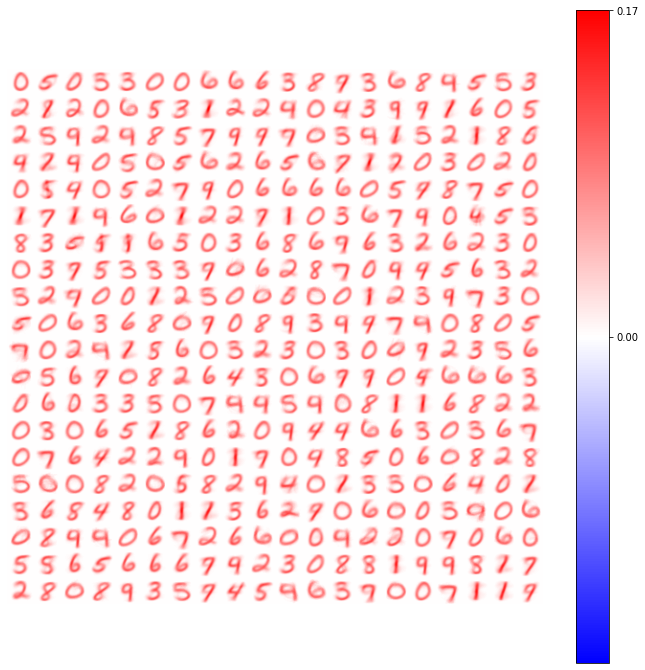

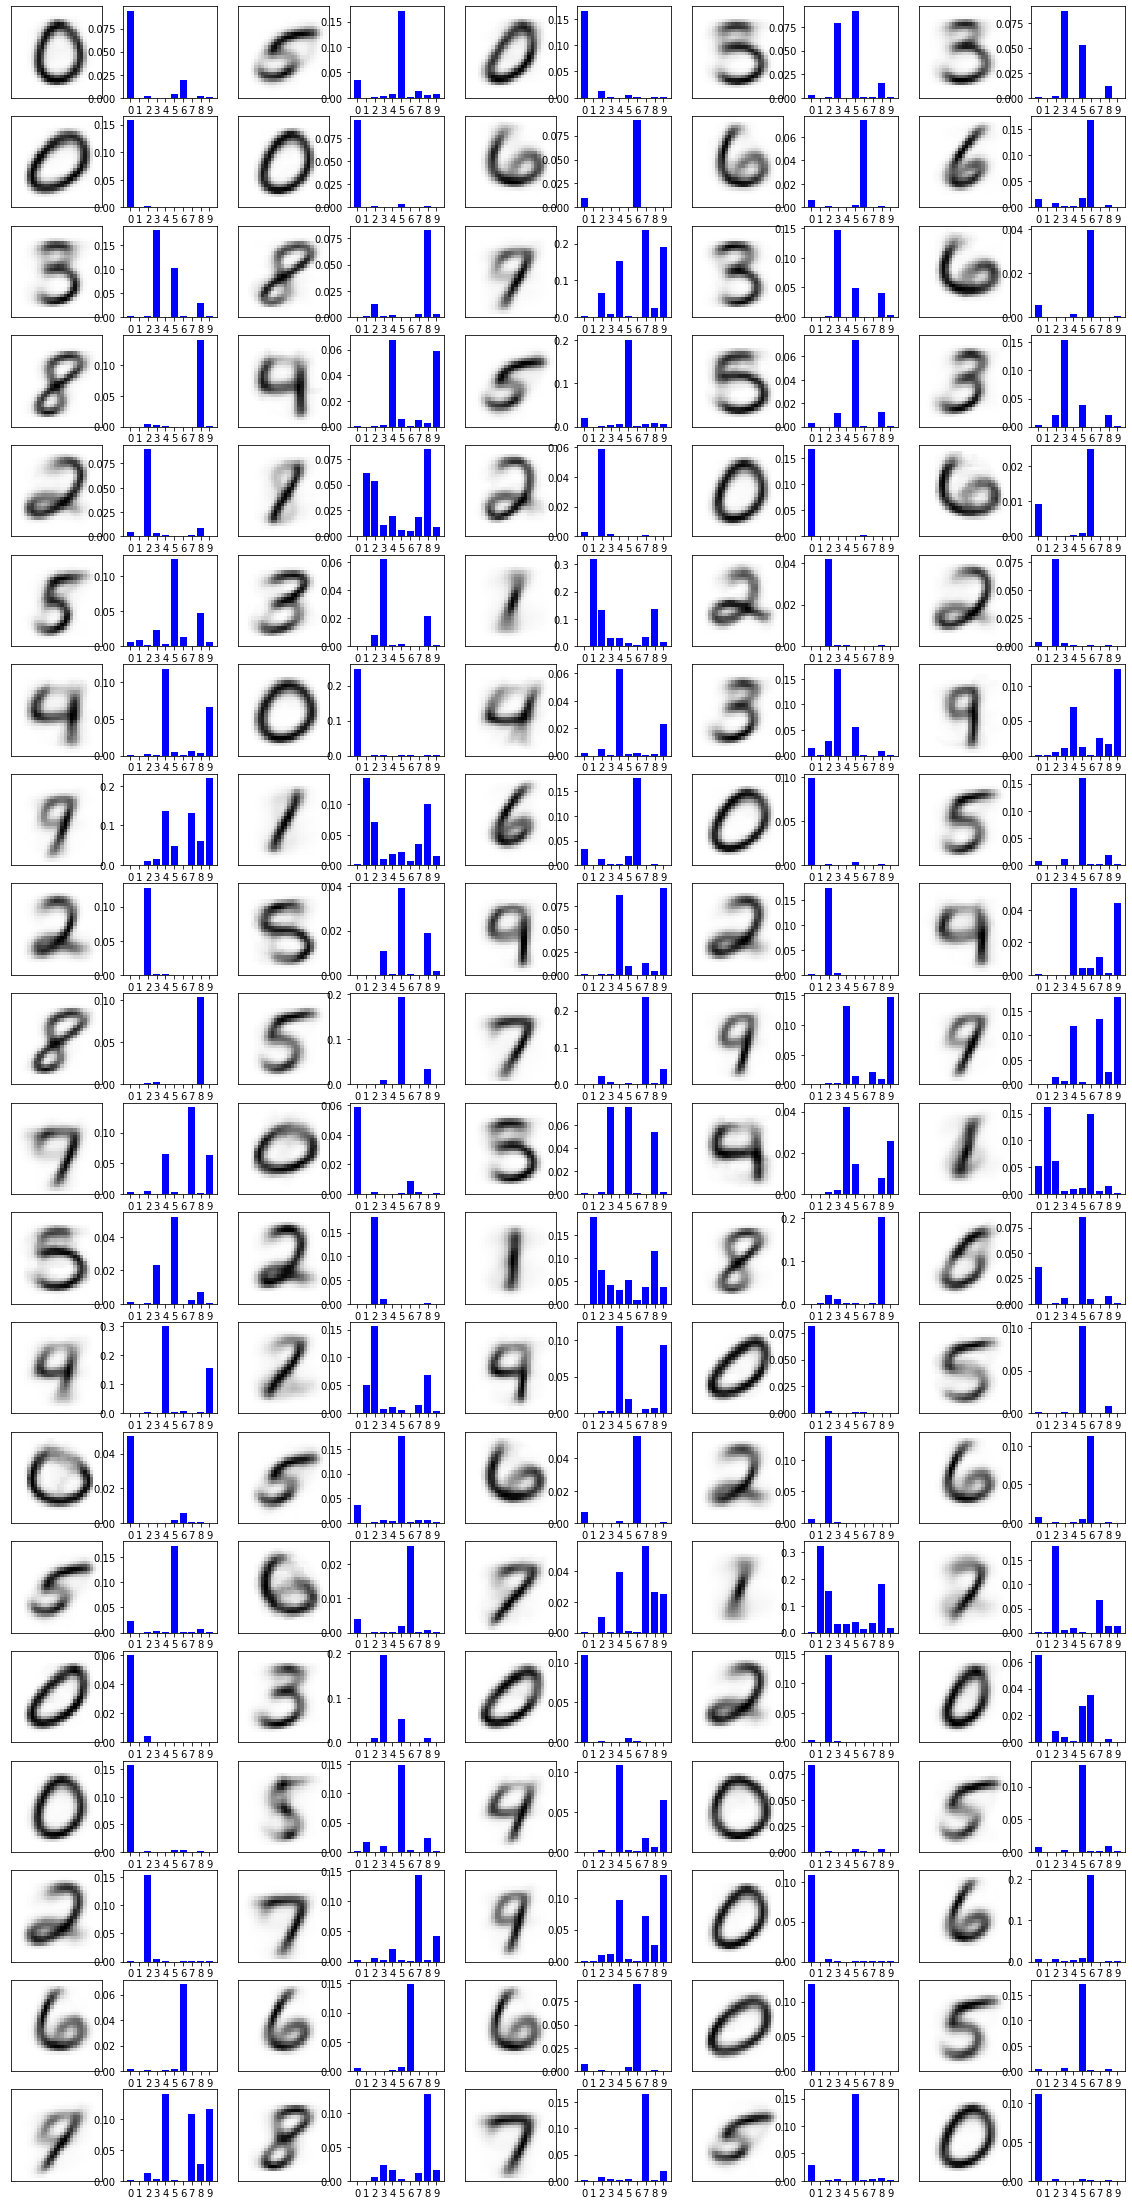

In [54]:
%matplotlib inline
# %matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 20
Ky = 20
Nep = 0
Tep = 20
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 400
beta = 0.1

N_c = 50

B = 500 #Batch size

(w, _, w_c) = multi_comp_classification(flat_x, S, L, Kx, Ky, N_c, Nep, Tep, T_s, xi, phi, B, zeta, beta)

plot_everything(w, w_c, 5, 20)

100%|███████████████████████████████████████████████████████████████| 120/120 [00:56<00:00,  2.13it/s]


Max val:  0.7612788965889735 Min value:  0.016993265852474154 Mean val:  0.6547653201385369 Std:  0.05568780290517344
Elapsed time:  1681.2407212257385  seconds
Misclassifieds:  [ 37. 127. 145.  99. 332. 141.  42. 223. 219. 560.]
Accuracy:  80.75 %


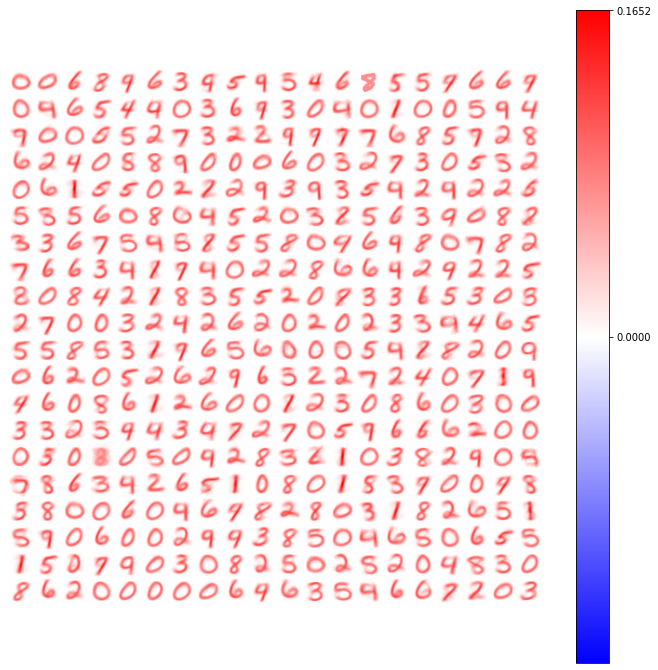

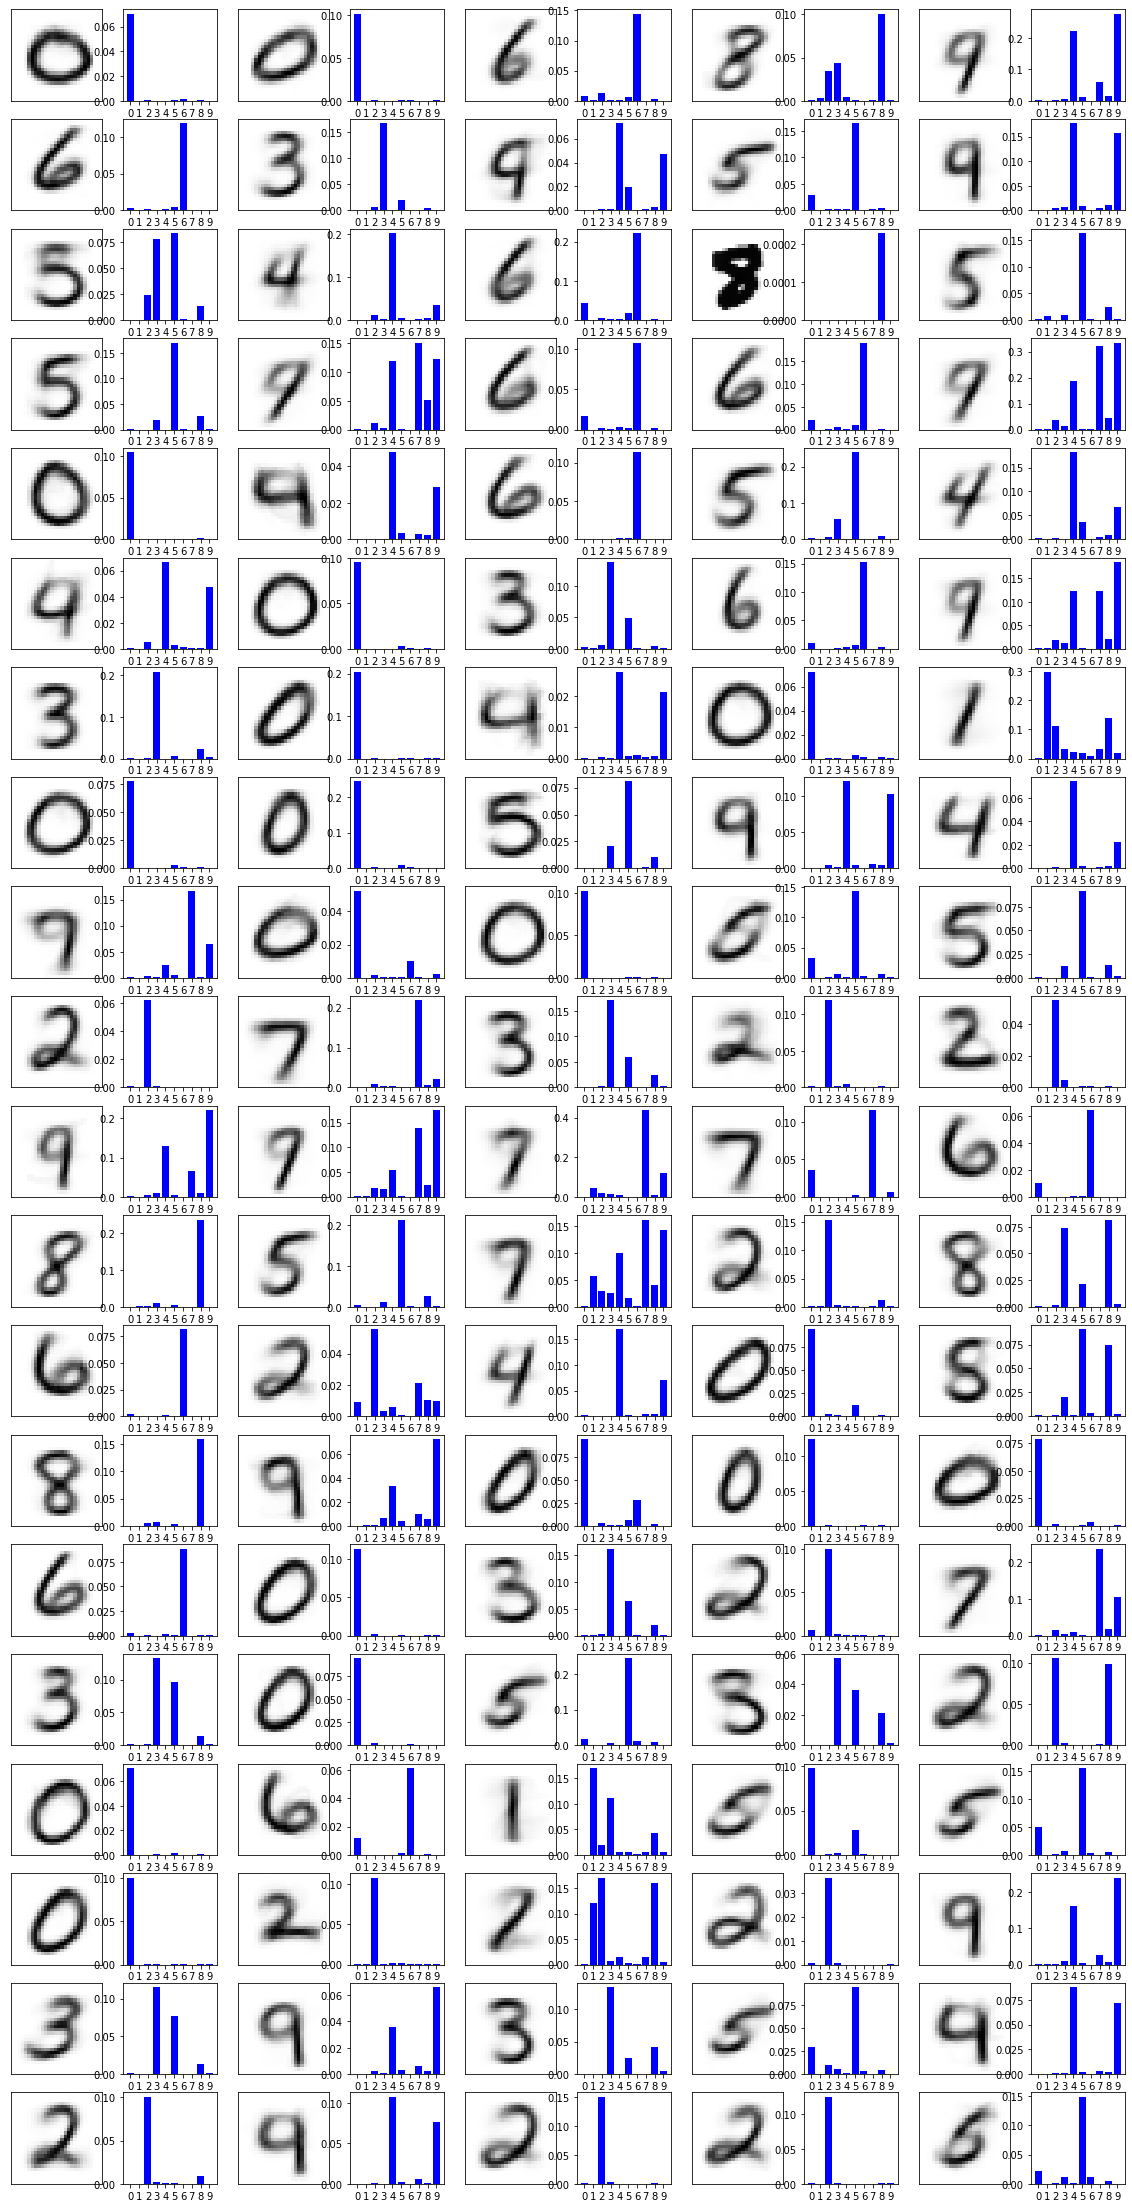

In [55]:
%matplotlib inline
# %matplotlib notebook
fig=plt.figure(figsize=(12,12))

Kx = 20
Ky = 20
Nep = 0
Tep = 30
T_s = 60000
xi = 0.1
phi = 2 / 501

zeta = 400
beta = 0.1

N_c = 100

B = 500 #Batch size

(w, _, w_c) = multi_comp_classification(flat_x, S, L, Kx, Ky, N_c, Nep, Tep, T_s, xi, phi, B, zeta, beta)

plot_everything(w, w_c, 5, 20)

Well, I didn't expect it to do *that* bad.  Good justice.  Let's talk about why this is messing up so badly.

I think there are a couple reasons.  First things first, at the end of the day, these are prototypes, and prototypes can't describe everything.  So it doesn't matter that you have more opinions.  You basically just have more wrong opinions.  

Actually I think that's really all it is.  Let's go to the conclusion.

## Conclusions

The best thing about this experiment is now I have the code, bitch.  I have the distributed code, and now I have a rough estimate of how long it takes to run.  Pretty fucking long.  

However.  This experiment was basically a flop.  I think the only possible thing to do moving forward is to take the input apart into multiple pieces.  We need some collaboration.  That's what we need.  We need the network to understand the parts out of which a two is formed.  I think only then will we start to get some good juice.  

I mean, that's basically a CNN.  But yeah, you can distribute competition all you like.  But you can't get away from the fact that the network only knows about so many prototypes.

## Next steps

Make a network that learns about the parts that constitute the whole.  That is all.